# SRI 2021 Fully Coherent Simulation

SRWLIB Python Example # 19:
Simulating Coherent X-ray (Gaussian beam) Scattering from ensemble of 3D particles modifying their positions due to Brownian motion
1 groups of coherent modes with 1 per group loaded
   Performing Simulaitons for the Initial Nano-Particle Distribution ***********
   Setting up Transmission optical element from input Sample data ... done in 0.292 s
   Extracting Optical Path Difference data from Sample Transmission optical element ... done in 0.0 s
   Saving Optical Path Difference data from Sample Transmission optical element ... done in 0.0 s
   Propagating Wavefront Group #0... done in 1.088 s
   Extracting, Projecting the Propagated Wavefront Intensity on Detector and Saving it to file ... done in 0.041 s
used bytes (MiB):  722.8310546875
total bytes (MiB):  827.78955078125
   Plotting the results (i.e. creating plots without showing them yet) ... done


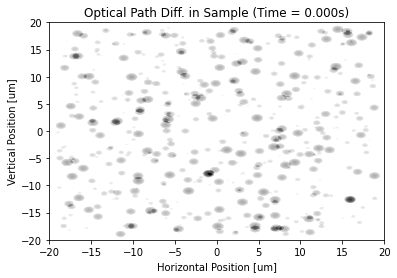

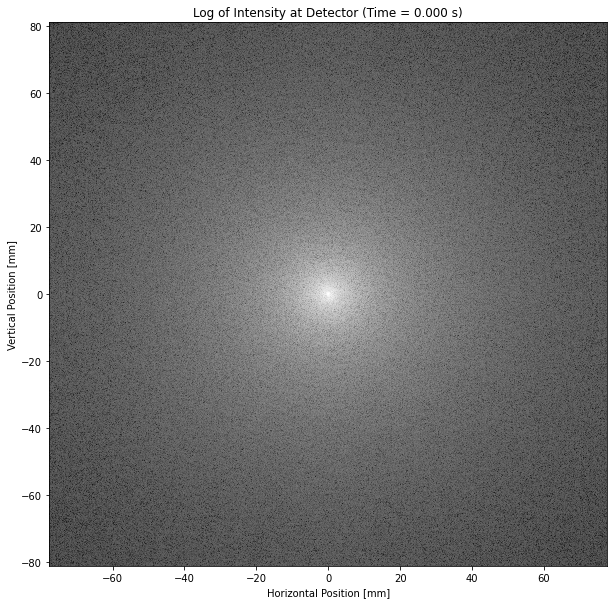

In [1]:
#############################################################################
# SRWLIB Example#19: Simulating Coherent X-ray (Gaussian beam) Scattering from ensemble
# of 3D Nano-Particles modifying their positions due to Brownian motion
# Authors: H. Goel (SBU/ECE), O.C. (BNL/NSLS-II)
# v 0.02
#############################################################################

from __future__ import print_function
from tabnanny import check #Python 2.7 compatibility
from srwlib import *
from srwl_uti_smp import *
import srwl_uti_smp_rnd_obj3d
import matplotlib.pyplot as plt
#%matplotlib widget
from uti_plot import * #required for plotting
import os
import time

if useCuPy:
    import cupy as cp
else:
    import numpy as cp

npIsAvail = False
try:
    import numpy as np
    npIsAvail = True
except:
    print('NumPy can not be loaded. You may need to install numpy, otherwise some functionality of this example will not be available. If you are using pip, you can use the following command to install it: \npip install numpy')

print('SRWLIB Python Example # 19:')
print('Simulating Coherent X-ray (Gaussian beam) Scattering from ensemble of 3D particles modifying their positions due to Brownian motion')

if useCuPy:
    gpu_id = 1
else:
    gpu_id = 0

#***********Folder and Data File Names
strDataFolderName = 'data_example_19' #Data sub-folder name
strSampleSubFolderName = 'samples' #Sub-folder name for storing Sample data
strListSampObjFileName = 'ex19_smp_obj_list_%d.dat' #List of 3D Nano-Objects / Sample file name
strSampOptPathDifOutFileName = 'ex19_smp_opt_path_dif_%d.dat' #optical path difference corresponding to selected sample
strIntInitOutFileName = 'ex19_res_int_in.dat' #initial wavefront intensity distribution output file name
strIntPropOutFileName = 'ex19_res_int_prop_%d.dat' #propagated wavefront intensity distribution output file name
strIntPropOutFileNameDet = 'ex19_res_int_det.h5' #intensity distribution regisgtered by detector output file name
strCmDataFileName = 'chx_res_pr_dir_100k_cm.h5' #file name for loading coherent modes from file

#***********Initial Wavefront
wfrs_summed = []
def sum_wavefronts(wfr):
    global wfrs_summed
    nTot = wfr.mesh.nx * wfr.mesh.ny * wfr.mesh.ne * 2
    arExS = cp.zeros(nTot, dtype=cp.float32)
    arEyS = cp.zeros(nTot, dtype=cp.float32)

    for i in range(wfr.nWfr):
        wfrC = deepcopy(wfr)
        wfrC.nWfr = 1
        wfrC.arEx = wfr.arEx[i*nTot: (i+1)*nTot]
        wfrC.arEy = wfr.arEy[i*nTot: (i+1)*nTot]
        wfrs_summed.append(wfrC)

        arExS += wfr.arEx[i*nTot: (i+1)*nTot]
        arEyS += wfr.arEy[i*nTot: (i+1)*nTot]

    wfrS = deepcopy(wfr)
    wfrS.nWfr = 1
    wfrS.arEx = arExS
    wfrS.arEy = arEyS
    return wfrS

def check_wavefronts(wfr):
    nTot = wfr.mesh.nx * wfr.mesh.ny * wfr.mesh.ne * 2
    arExS = cp.zeros(nTot, dtype=cp.float32)
    arEyS = cp.zeros(nTot, dtype=cp.float32)

    for i in range(wfr.nWfr):
        if i == 0:
            arExS += wfr.arEx[i*nTot: (i+1)*nTot]
            arEyS += wfr.arEy[i*nTot: (i+1)*nTot]
        if i >= 1:
            if not cp.array_equal(arExS, wfr.arEx[i*nTot: (i+1)*nTot]):
                print(cp.mean( (arExS - wfr.arEx[i*nTot: (i+1)*nTot]) ** 2 ))
                print("arEx Not equal")
            if not cp.array_equal(arEyS, wfr.arEy[i*nTot: (i+1)*nTot]):
                print(cp.mean( (arEyS - wfr.arEy[i*nTot: (i+1)*nTot]) ** 2 ))
                print("arEy Not equal")



def uti_read_wfr_cm_hdf5(_file_path, _gen0s=True, _wfrs_per_grp = 100): #OC11042020
    """
    Reads-in Wavefront data file (with a number of wavefronts, calculated in the same mesh vs x nad y)
    :param _file_path: string specifying path do data file to be loaded
    :param _gen0s: switch defining whether zero-electric field array(s) need to be created if some polarization component(s) are missing in the file 
    :return: list of wavefronts (objects of SRWLWfr type)
    """
    ### Load package numpy
    try:
        import numpy as np
    except:
        raise Exception('NumPy can not be loaded. You may need to install numpy. If you are using pip, you can use the following command to install it: \npip install numpy')

    ### Load package h5py
    try:
        import h5py as h5
    except:
        raise Exception('h5py can not be loaded. You may need to install h5py. If you are using pip, you can use the following command to install it: \npip install h5py')

    wfr = SRWLWfr() #auxiliary wavefront
    mesh = wfr.mesh

    hf = h5.File(_file_path, 'r')

    #Get attributes
    ats = hf.attrs
    mesh.eStart = float(ats.get('eStart'))
    mesh.eFin = float(ats.get('eFin'))
    mesh.ne = int(ats.get('ne'))
    mesh.xStart = float(ats.get('xStart'))  
    mesh.xFin = float(ats.get('xFin'))
    mesh.nx = int(ats.get('nx'))
    mesh.yStart = float(ats.get('yStart'))
    mesh.yFin = float(ats.get('yFin'))
    mesh.ny = int(ats.get('ny'))
    mesh.zStart = float(ats.get('zStart'))

    try: #OC09052021 (to walk around cases when this input is absent)
        wfr.numTypeElFld = ats.get('numTypeElFld')
        wfr.Rx = float(ats.get('Rx'))
        wfr.Ry = float(ats.get('Ry'))
        wfr.dRx = float(ats.get('dRx'))
        wfr.dRy = float(ats.get('dRy'))
        wfr.xc = float(ats.get('xc'))
        wfr.yc = float(ats.get('yc'))
        wfr.avgPhotEn = float(ats.get('avgPhotEn'))
        wfr.presCA = int(ats.get('presCA'))
        wfr.presFT = int(ats.get('presFT'))
        wfr.unitElFld = int(ats.get('unitElFld'))
        wfr.unitElFldAng = int(ats.get('unitElFldAng'))
    except:
        wfr.numTypeElFld = 'f'
        wfr.Rx = 0
        wfr.Ry = 0
        wfr.dRx = 0
        wfr.dRy = 0
        wfr.xc = 0
        wfr.yc = 0
        wfr.avgPhotEn = 0
        wfr.presCA = 0
        wfr.presFT = 0
        wfr.unitElFld = 1
        wfr.unitElFldAng = 0

    #Get All Electric Field data sets
    arEx = None
    arExH5 = hf.get('arEx')
    if(arExH5 is not None):
        arEx = np.array(arExH5)[:1] #.reshape(-1)
        #arEx = [arEx[1], arEx[0]]
        #arEx = [arEx, arEx]

    arEy = None
    arEyH5 = hf.get('arEy')
    if(arEyH5 is not None):
        arEy = np.array(arEyH5)[:1] #.reshape(-1)
        #arEy = [arEy[1], arEy[0]]
        #arEy = [arEy, arEy]

    nWfr = 0
    lenArE = 0
    if(arEx is not None):
        nWfr = len(arEx)
        lenArE = len(arEx[0])
    elif(arEy is not None):
        nWfr = len(arEy)
        lenArE = len(arEy[0])

    grps = nWfr // _wfrs_per_grp
    if nWfr % _wfrs_per_grp != 0: grps += 1

    wfrs = []
    for grp in range(grps):
        nWfr_grp = min(nWfr - grp * _wfrs_per_grp, _wfrs_per_grp)

        arE0s = None #OC28062021
        if(_gen0s and (lenArE > 0)): arE0s = np.zeros(lenArE * nWfr_grp, dtype=np.float32) #OC28062021
        #arE0s = None if(lenArE <= 0) else np.array([0]*lenArE, 'f')
        
        wfrN = deepcopy(wfr)
        wfrN.nWfr = nWfr_grp
        if(arEx is not None):
            wfrN.arEx = np.concatenate(arEx[grp * _wfrs_per_grp : grp * _wfrs_per_grp + nWfr_grp])
        else:
            wfrN.arEx = copy(arE0s)

        if(arEy is not None):
            wfrN.arEy = np.concatenate(arEy[grp * _wfrs_per_grp : grp * _wfrs_per_grp + nWfr_grp])
        else:
            wfrN.arEy = copy(arE0s)
        wfrs.append(wfrN)

    #Tests
    #print(wfr.arEx)
    #print(wfr.arEy)

    return wfrs

wfr_list = uti_read_wfr_cm_hdf5(os.path.join(os.getcwd(), strDataFolderName, strCmDataFileName), _wfrs_per_grp=1)
print('{} groups of coherent modes with {} per group loaded'.format(len(wfr_list), wfr_list[0].nWfr))

#************Defining Samples (lists of 3D objects (spheres))
#Initial set of 3D objects
rx = 40.e-06 #Range of Horizontal position [m] within which 3D Objects constituing Sample are defined
ry = 40.e-06 #Range of Vertical position [m]
rz = 40.e-06 #Range of Longitudinal position [m]
xc = 0 #Horizontal Center position of the Sample
yc = 0 #Vertical Center position of the Sample
zc = 0 #Longitudinal Center position of the Sample

listObjInit = srwl_uti_smp_rnd_obj3d.setup_list_obj3d( #Initial list of 3D object (sphere) parameters
    _n = 500, #Number of 3D nano-objects
    _ranges = [0.95*rx, 0.95*ry, rz], #Ranges of horizontal, vertical and longitudinal position within which the 3D objects are defined
    #_ranges = [rx, ry, rz], #Ranges of horizontal, vertical and longitudinal position within which the 3D objects are defined
    _cen = [xc, yc, zc], #Horizontal, Vertical and Longitudinal coordinates of center position around which the 3D objects are defined
    _dist = 'uniform', #Type (and eventual parameters) of distributions of 3D objects
    _obj_shape = ['S', 'uniform', 150.e-09, 1500.e-09], #Type of 3D objects, their distribution type and parameters (min. and max. diameter for the 'uniform' distribution)
    _allow_overlap = False, #Allow or not the 3D objects to overlap
    _seed = 0,
    _fp = os.path.join(os.getcwd(), strDataFolderName, strSampleSubFolderName, strListSampObjFileName%(0)))
    
#Generate timesteps of Brownian motion of the 3D nano-objects (spheres) simulating particles suspended in water at room temperature
timeStep = 0.0001 #Time step between different Sample "snapshots" / scattering patterns
timeInterv = timeStep * (100 - 1) #Total time interval covered by the "snapshots"
listObjBrownian = srwl_uti_smp_rnd_obj3d.brownian_motion3d(
    _obj_crd = listObjInit, #Initial list of 3D objects
    _viscosity = 5.e-3, #[Pa*s]
    _temperature = 293, #[K]
    _timestep = timeStep, #[s]
    _duration = timeInterv, #[s]
    _seed = 0,
    _fp = os.path.join(os.getcwd(), strDataFolderName, strSampleSubFolderName, strListSampObjFileName))[:1]

#Sample Material Characteristics (Au at 8 keV)
matDelta = 4.773e-05 #Refractive Index Decrement
matAttenLen = 2.48644e-06 #Attenuation Length [m]

#***********Detector
nxDet = 2070 #Detector Number of Pixels in Horizontal direction
nyDet = 2167 #Detector Number of Pixels in Vertical direction
pSize = 75e-06 #Detector Pixel Size
xrDet = nxDet*pSize
yrDet = nyDet*pSize
det = SRWLDet(_xStart = -0.5*xrDet, _xFin = 0.5*xrDet, _nx = nxDet, _yStart = -0.5*yrDet, _yFin = 0.5*yrDet, _ny = nyDet)
det_fc = SRWLDet(_xStart = -0.5*xrDet, _xFin = 0.5*xrDet, _nx = nxDet, _yStart = -0.5*yrDet, _yFin = 0.5*yrDet, _ny = nyDet)

arDetFrames = None #Array to store all detector frames data
if(npIsAvail): arDetFrames = np.zeros((len(listObjBrownian), nxDet, nyDet))

#***********Defining Drift from Sample to Detector and Propagation Parameters
distSmp_Det = 16.
opSmp_Det = SRWLOptD(distSmp_Det)

#Wavefront Propagation Parameters:
#[0]: Auto-Resize (1) or not (0) Before propagation
#[1]: Auto-Resize (1) or not (0) After propagation
#[2]: Relative Precision for propagation with Auto-Resizing (1. is nominal)
#[3]: Allow (1) or not (0) for semi-analytical treatment of the quadratic (leading) phase terms at the propagation
#[4]: Do any Resizing on Fourier side, using FFT, (1) or not (0)
#[5]: Horizontal Range modification factor at Resizing (1. means no modification)
#[6]: Horizontal Resolution modification factor at Resizing
#[7]: Vertical Range modification factor at Resizing
#[8]: Vertical Resolution modification factor at Resizing
#[9]: Type of wavefront Shift before Resizing
#[10]: New Horizontal wavefront Center position after Shift
#[11]: New Vertical wavefront Center position after Shift
#           [0][1][2] [3][4] [5] [6] [7]  [8]  [9][10][11] 
ppSmp =     [0, 0, 1., 0, 0, 1., 55.*2, 1., 55.*2,  0, 0, 0]
ppSmp_Det = [0, 0, 1., 3, 0, 1., 1.,  1.,  1.,  0, 0, 0]
ppFin =     [0, 0, 1., 0, 0, 1., 1.,  1.,  1.,  0, 0, 0]

#***********Wavefront Propagation / Scattering calculation for different instances of Sample created by Brownnian motion
for it in range(len(listObjBrownian)):

    if(it == 0): print('   Performing Simulaitons for the Initial Nano-Particle Distribution ***********')
    else: print('   Performing Simulaitons for Brownian Motion Step:', it, '***********')

    print('   Setting up Transmission optical element from input Sample data ... ', end='')
    t = time.time()
    opSmp = srwl_opt_setup_transm_from_obj3d( #Defining Sample (Transmission object)
        shape_defs = listObjBrownian[it], #List of 3D Nano-Object params for the current step
        delta = matDelta, atten_len = matAttenLen, #3D Nano-Object Material params
        rx = rx, ry = ry, #Range of Horizontal and Vertical position [m] within which Nano-Objects constituing the Sample are defined
        nx = 4000, ny = 4000, #Numbers of points vs Horizontal and Vertical position for the Transmission
        xc = xc, yc = yc, #Horizontal and Vertical Center positions of the Sample
        extTr = 1) #Transmission outside the grid/mesh is zero (0), or the same as on boundary (1)
    print('done in', round(time.time() - t, 3), 's')

    print('   Extracting Optical Path Difference data from Sample Transmission optical element ... ', end='')
    t = time.time()
    opPathDif = opSmp.get_data(_typ = 3, _dep = 3)

    print('done in', round(time.time() - t, 3), 's')

    print('   Saving Optical Path Difference data from Sample Transmission optical element ... ', end='')
    t = time.time()
    #srwl_uti_save_intens_ascii(
    #    opPathDif, opSmp.mesh, os.path.join(os.getcwd(), strDataFolderName, strSampOptPathDifOutFileName%(it)), 0,
    #    ['Photon Energy', 'Horizontal Position', 'Vertical Position', 'Optical Path Difference'], _arUnits=['eV', 'm', 'm', 'm'])
    print('done in', round(time.time() - t, 3), 's')

    #Defining "Beamline" to Propagate the Wavefront through
    opBL = SRWLOptC([opSmp, opSmp_Det], 
                    [ppSmp, ppSmp_Det, ppFin])
    
    idx = 0
    wfrP_list = deepcopy(wfr_list)
    cmFrames = []
    cmFrame_fc = None
    arI1 = None
    for wfrP in wfrP_list:
        print('   Propagating Wavefront Group #%d... '%(idx), end='')
        t = time.time()

        srwl.PropagElecField(wfrP, opBL, None, gpu_id)
        print('done in', round(time.time() - t, 3), 's')

        print('   Extracting, Projecting the Propagated Wavefront Intensity on Detector and Saving it to file ... ', end='')
        
        t = time.time()
        mesh1 = deepcopy(wfrP.mesh)
        if arI1 is None:
            arI1 = cp.zeros(mesh1.nx*mesh1.ny*wfrP.nWfr, dtype=np.float32)#array('f', [0]*mesh1.nx*mesh1.ny*wfrP.nWfr) #"flat" array to take 2D intensity data
        srwl.CalcIntFromElecField(arI1, wfrP, 6, 0, 3, mesh1.eStart, 0, 0, None, None, gpu_id) #extracts intensity
        stkDet = det.treat_int(arI1, _mesh = mesh1, _nwfr = wfrP.nWfr, _gpu=gpu_id) #"Projecting" intensity on detector (by interpolation)
        if cmFrame_fc is None:
            stkDet2 = det_fc.treat_int(arI1, _mesh = mesh1, _nwfr = wfrP.nWfr, _gpu=gpu_id) #"Projecting" intensity on detector (by interpolation)
            if useCuPy:
                cmFrame_fc = stkDet2.arS.get()
            else:
                cmFrame_fc = stkDet2.arS
                
        mesh1 = deepcopy(stkDet.mesh)
        if useCuPy:
            cmFrames.append(stkDet.arS.get())
        else:
            cmFrames.append(stkDet.arS)
            
        print('done in', round(time.time() - t, 3), 's')
        
        del stkDet.arS
        del wfrP.arEx
        del wfrP.arEy

        if useCuPy:
            cupyMempool.free_all_blocks()
            print('used bytes (MiB): ', cupyMempool.used_bytes() / (1024 * 1024))
            print('total bytes (MiB): ', cupyMempool.total_bytes() / (1024 * 1024))
        
        idx+=1

    #Plotting the Results (requires 3rd party graphics package)
    print('   Plotting the results (i.e. creating plots without showing them yet) ... ', end='')
    
    cmArI1 = np.sum(cmFrames, axis=0)
    if(arDetFrames is not None): arDetFrames[it] = np.reshape(cmArI1, (mesh1.ny, mesh1.nx)).transpose()

    #Sample Optical Path Diff.
    meshS = opSmp.mesh
    plotMeshSx = [meshS.xStart, meshS.xFin, meshS.nx]
    plotMeshSy = [meshS.yStart, meshS.yFin, meshS.ny]
    if useCuPy:
        opPathDif = opPathDif.get()
    uti_plot2d(opPathDif, plotMeshSx, plotMeshSy, ['Horizontal Position', 'Vertical Position', 'Optical Path Diff. in Sample (Time = %.3fs)' % (it*timeStep)], ['m', 'm', 'm'])
    
    #Scattered Radiation Intensity Distribution in Log Scale
    plotMesh1x = [mesh1.xStart, mesh1.xFin, mesh1.nx]
    plotMesh1y = [mesh1.yStart, mesh1.yFin, mesh1.ny]
    nTot = mesh1.ne*mesh1.nx*mesh1.ny

    arLogI1 = copy(cmArI1)
    arLogI1 = np.clip(cmArI1, 0, None, arLogI1)
    arLogI1 = np.where(arLogI1 != 0, np.log10(arLogI1, out=arLogI1), 0)
    
    arLogI1_fc = copy(cmFrame_fc)
    arLogI1_fc = np.clip(cmFrame_fc, 0, None, arLogI1_fc)
    arLogI1_fc = np.where(arLogI1_fc != 0, np.log10(arLogI1_fc, out=arLogI1_fc), 0)
    #for i in range(nTot):
    #    curI = arI1[i]
    #    if(curI <= 0.): arLogI1[i] = 0 #?
    #    else: arLogI1[i] = log(curI, 10)

    fig = uti_plot2d(arLogI1, plotMesh1x, plotMesh1y, ['Horizontal Position', 'Vertical Position', 'Log of Intensity at Detector (Time = %.3f s)' % (it*timeStep)], ['m', 'm', ''])
    fig.set_size_inches(10, 10)
    #uti_plot2d1d(arLogI1, plotMesh1x, plotMesh1y, 0, 0, ['45 degree diagonal', '-45 degree diagonal', 'Log of Intensity at Detector (Time = %.3f s)' % (it*timeStep)], ['m', 'm', ''], _diagonals=True)
    print('done')

    #if(arDetFrames is not None): #Saving simulated Detector data file
    #    print('   Saving all Detector data to another file (that can be used in subsequent processing) ... ', end='')
    #    srwl_uti_save_intens_hdf5_exp(arDetFrames, mesh1, os.path.join(os.getcwd(), strDataFolderName, strIntPropOutFileNameDet), 
    #        _exp_type = 'XPCS', _dt = timeStep, _dist_smp = distSmp_Det, _bm_size_x = GsnBm.sigX*2.35, _bm_size_y = GsnBm.sigY*2.35)
    #    print('done')

uti_plot_show() #Show all plots created


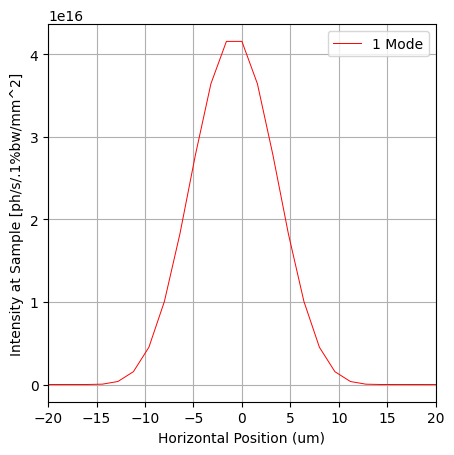

In [2]:
mesh0 = deepcopy(wfr_list[0].mesh)
arI0 = array('f', [0]*mesh0.nx*mesh0.ny) #"flat" array to take 2D intensity data
srwl.CalcIntFromElecField(arI0, wfr_list[0], 6, 0, 3, mesh0.eStart, 0, 0) #Extract intensity
#srwl_uti_save_intens_ascii( #Save Intensity of to a file
#    arI0, mesh0, os.path.join(os.getcwd(), strDataFolderName, strIntInitOutFileName), 0,
#    ['Photon Energy', 'Horizontal Position', 'Vertical Position', 'Intensity'], _arUnits=['eV', 'm', 'm', 'ph/s/.1%bw/mm^2'])

h_cut = np.array(arI0).reshape(mesh0.ny, mesh0.nx)[mesh0.ny // 2]
h_scale = 1000000

#Plot the Initial Wavefront (without showing it yet)
#plotMesh0x = [mesh0.xStart, mesh0.xFin, mesh0.nx]
#plotMesh0y = [mesh0.yStart, mesh0.yFin, mesh0.ny]
#fig = uti_plot2d1d(arI0, plotMesh0x, plotMesh0y, 0, 0, ['Horizontal Position', 'Vertical Position', 'Intensity at Sample'], ['m', 'm', 'ph/s/.1%bw/mm^2'])
plt.figure(dpi=100, figsize=(5, 5))
#plt.title("Coherent Modes")
plt.xlabel("Horizontal Position (um)")
plt.ylabel("Intensity at Sample [ph/s/.1%bw/mm^2]")
plt.plot(np.arange(mesh0.xStart * h_scale, mesh0.xFin * h_scale, (mesh0.xFin - mesh0.xStart) * h_scale/len(h_cut)), h_cut, label="1 Mode", color="red", linewidth=0.7)
plt.xlim(-20, 20)
#plt.plot(np.arange(diagStart, diagFin, (diagFin - diagStart)/len(diag0_pc)), diag0_pc, label="Partially Coherent", color="blue", linewidth=0.7)
plt.legend()
plt.grid(True, which="both")
plt.show()

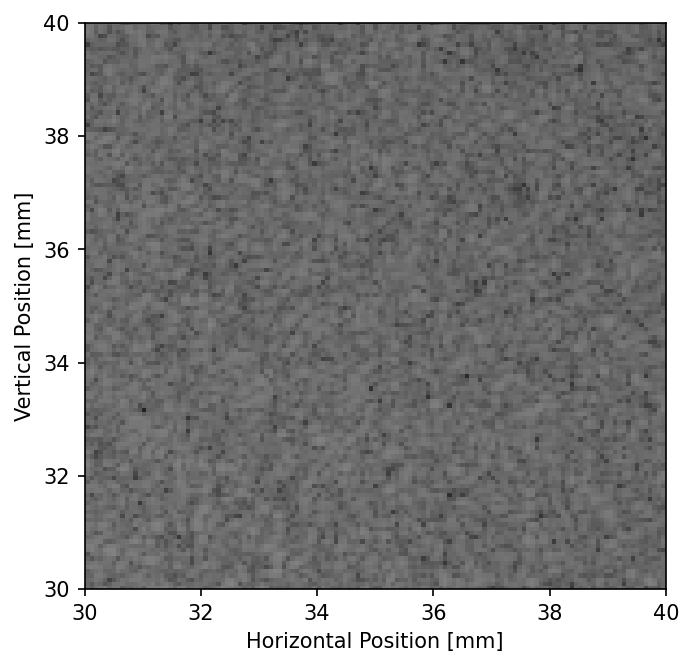

In [3]:
fig = uti_plot2d(arLogI1, plotMesh1x, plotMesh1y, ['Horizontal Position', 'Vertical Position', ''], ['m', 'm', ''])
plt.xlim(30, 40)
plt.ylim(30, 40)
fig.set_size_inches(5, 5)
fig.set_dpi(150)
uti_plot_show()

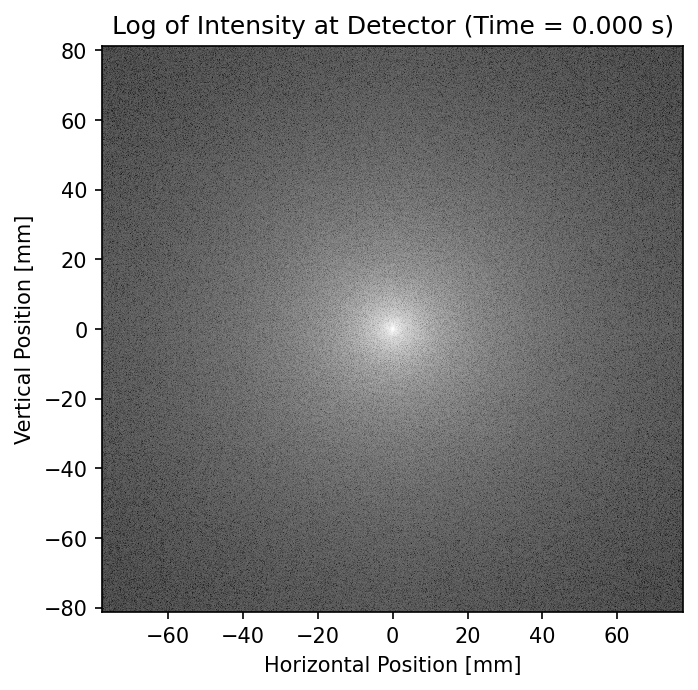

In [4]:
fig = uti_plot2d(arLogI1, plotMesh1x, plotMesh1y, ['Horizontal Position', 'Vertical Position', 'Log of Intensity at Detector (Time = %.3f s)' % (it*timeStep)], ['m', 'm', ''])
fig.set_size_inches(5, 5)
fig.set_dpi(150)
uti_plot_show()

In [5]:
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 12})

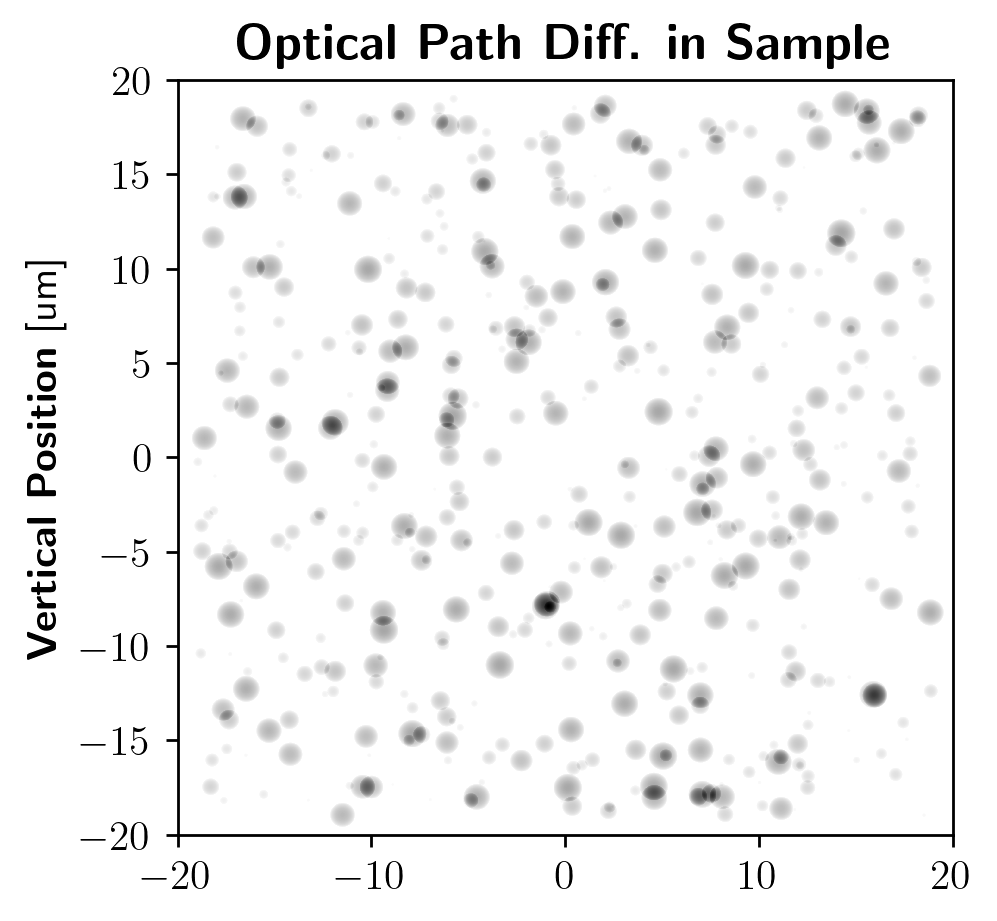

In [6]:
fig = uti_plot2d(opPathDif, plotMeshSx, plotMeshSy, [r'\textbf{Horizontal Position}', r'\textbf{Vertical Position}', r'\textbf{Optical Path Diff. in Sample}'], ['m', 'm', 'm'])
fig.set_size_inches(4, 4)
fig.set_dpi(250)
plt.xlabel("")
uti_plot_show()

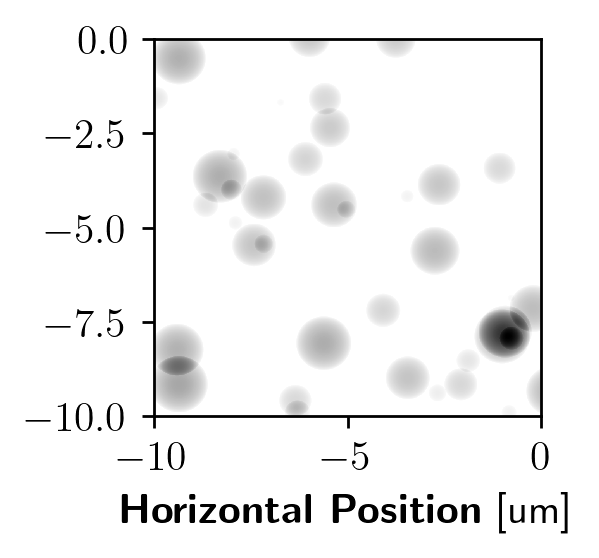

In [10]:
fig = uti_plot2d(opPathDif, plotMeshSx, plotMeshSy, [r'\textbf{Horizontal Position}', r'\textbf{Vertical Position}', ''], ['m', 'm', ''])
plt.xlim(-10, 0)
plt.ylim(-10, 0)
plt.ylabel("")
fig.set_size_inches(2, 2)
fig.set_dpi(250)
uti_plot_show()

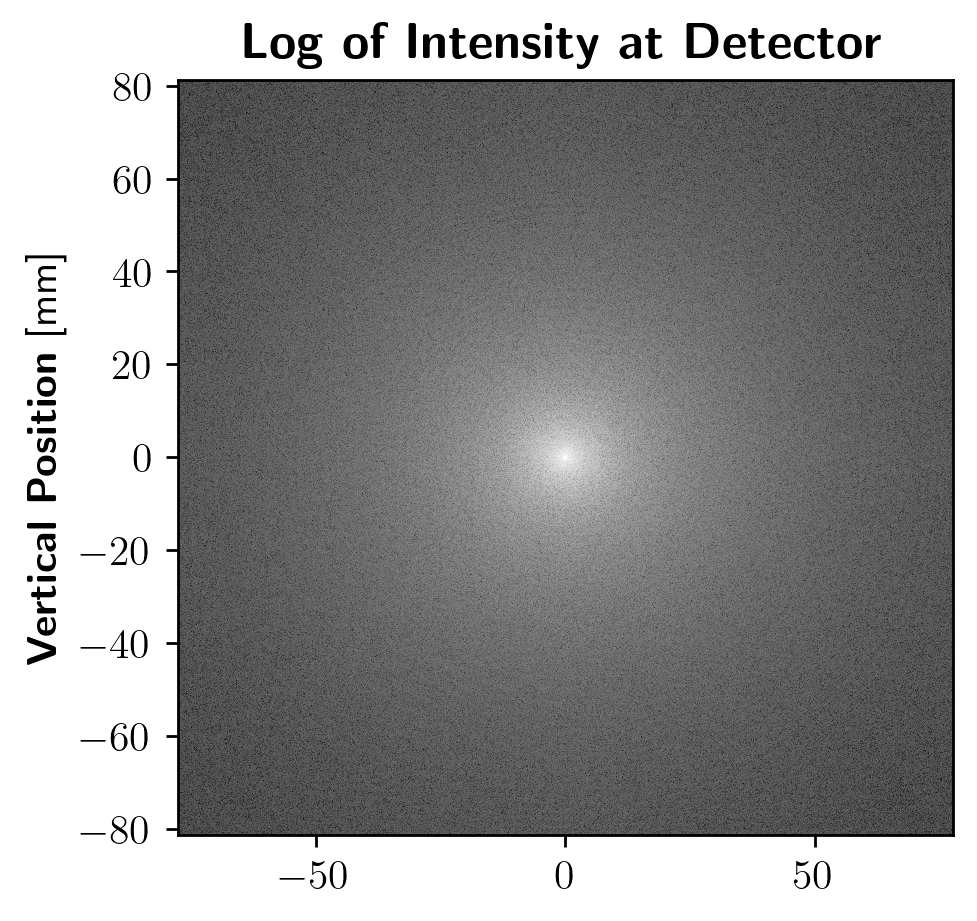

In [8]:
fig = uti_plot2d(arLogI1, plotMesh1x, plotMesh1y, [r'\textbf{Horizontal Position}', r'\textbf{Vertical Position}', r'\textbf{Log of Intensity at Detector}'], ['m', 'm', ''])
fig.set_size_inches(4, 4)
fig.set_dpi(250)
plt.xlabel("")
uti_plot_show()

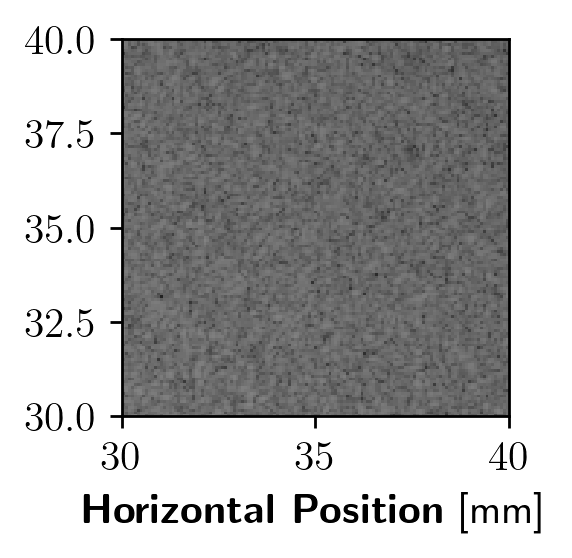

In [9]:
fig = uti_plot2d(arLogI1, plotMesh1x, plotMesh1y, [r'\textbf{Horizontal Position}', r'\textbf{Vertical Position}', ''], ['m', 'm', ''])
plt.xlim(30, 40)
plt.ylim(30, 40)
plt.ylabel("")
fig.set_size_inches(2, 2)
fig.set_dpi(250)
uti_plot_show()